# **Predicting Berry Edibility on the Mysterious Island**

## Goal: Determine a set of reliable rules to identify which berries are edible.

We will use the notes from `edible.json` and compare three classification models:
1. Our custom-built Decision Tree (`BasicTreeClassifier`)
2. Our custom-built Naive Bayes classifier (`CategoricalNB`)
3. The industry-standard `sklearn.tree.DecisionTreeClassifier`

The primary objective is to find clear, interpretable rules for survival.

## **Import Libraries**
Import all necessary libraries for data handling, machine learning, visualization, and table formatting.

In [57]:
# Import python libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree, plot_tree

# Import our custom-built classifiers from the `scripts` directory.
scripts_path = os.path.abspath(os.path.join('..', 'scripts'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from BasicTree import BasicTreeClassifier
from naiveBayes import CategoricalNB

print("All libraries and custom modules imported successfully.")


All libraries and custom modules imported successfully.


## **Load Data and Define Visual Style**

In [58]:
# Define a Custom Color Palette for our Plots
PALETTE = {
    'edible': '#2a9d8f',      # Teal Green
    'inedible': '#e76f51',    # Burnt Sienna
    'primary': '#264653',     # Dark Slate Gray
    'accent': '#f4a261',      # Sandy Brown
    'background': '#f1faee'
}

# Set the global style for all plots in the notebook
sns.set_style("whitegrid", {'axes.facecolor': PALETTE['background']})
plt.rc('figure', facecolor=PALETTE['background'])
plt.rc('axes', edgecolor=PALETTE['primary'], labelcolor=PALETTE['primary'], titlecolor=PALETTE['primary'])
plt.rc('text', color=PALETTE['primary'])
plt.rc('xtick', color=PALETTE['primary'])
plt.rc('ytick', color=PALETTE['primary'])

# --- Load Data ---
data_path = os.path.join('..', 'data', 'edible.json')
edible_df = pd.read_json(data_path)


## **Exploratory Data Analysis (EDA)**
Before modeling, we must understand our data. We'll use styled tables and custom plots to check the data's shape, types, distributions, and look for any missing values.

1. Basic DataFrame Information
╒═════════════════════╤════════════════╤══════════════════╕
│ Shape               │ Memory Usage   │ Missing Values   │
╞═════════════════════╪════════════════╪══════════════════╡
│ 500 rows, 4 columns │ 80.31 KB       │ None             │
╘═════════════════════╧════════════════╧══════════════════╛

2. Data Types and Non-Null Counts
╒══════════════╤══════════════════╤═════════════╕
│ Column       │   Non-Null Count │ Data Type   │
╞══════════════╪══════════════════╪═════════════╡
│ leaf_shape   │              500 │ object      │
├──────────────┼──────────────────┼─────────────┤
│ petal_colour │              500 │ object      │
├──────────────┼──────────────────┼─────────────┤
│ berry_colour │              500 │ object      │
├──────────────┼──────────────────┼─────────────┤
│ edible       │              500 │ bool        │
╘══════════════╧══════════════════╧═════════════╛

3. Descriptive Statistics for All Features
╒══════════════╤═════════╤══════════╤═══

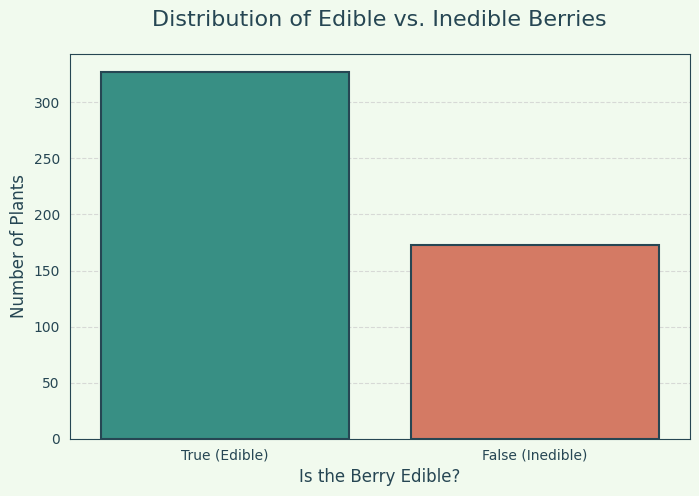

In [59]:
# 
print("1. Basic DataFrame Information")
info_data = {
    "Shape": [f"{edible_df.shape[0]} rows, {edible_df.shape[1]} columns"],
    "Memory Usage": [f"{edible_df.memory_usage(deep=True).sum() / 1024:.2f} KB"],
    "Missing Values": ["None" if edible_df.isnull().sum().sum() == 0 else "Present"]
}
print(tabulate(info_data, headers="keys", tablefmt="fancy_grid"))

print("\n2. Data Types and Non-Null Counts")
info_df = pd.DataFrame({
    'Column': edible_df.columns,
    'Non-Null Count': edible_df.count().values,
    'Data Type': edible_df.dtypes.values
})
print(tabulate(info_df, headers="keys", tablefmt="fancy_grid", showindex=False))

print("\n3. Descriptive Statistics for All Features")
# For categorical data, describe() gives count, unique, top (mode), and freq
desc_stats = edible_df.describe(include=['object', 'bool']).transpose()
print(tabulate(desc_stats, headers="keys", tablefmt="fancy_grid"))

print("\n4. Target Variable Distribution (Edibility)")
plt.figure(figsize=(8, 5))
sns.countplot(
    x='edible',
    data=edible_df,
    palette=[PALETTE['edible'], PALETTE['inedible']],
    hue='edible',  # Assign the 'x' variable to 'hue'
    legend=False,  # Disable the legend as it's redundant here
    edgecolor=PALETTE['primary'],
    linewidth=1.5
)
# --- END OF CORRECTION ---

plt.title('Distribution of Edible vs. Inedible Berries', fontsize=16, pad=20)
plt.xlabel('Is the Berry Edible?', fontsize=12)
plt.ylabel('Number of Plants', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['True (Edible)', 'False (Inedible)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Preprocessing**
We convert our categorical data into a numerical format that the models can understand using `LabelEncoder`.

In [60]:
# Data Preprocessing
df_proc = edible_df.copy()
encoders = {}

for col in df_proc.columns:
    if df_proc[col].dtype == 'object' or df_proc[col].dtype == 'bool':
        le = LabelEncoder()
        df_proc[col] = le.fit_transform(df_proc[col])
        encoders[col] = le

print("Preprocessed (Numerical) Data")
print(tabulate(df_proc, headers="keys", tablefmt="fancy_grid", showindex=False))

# --- Feature and Target Split ---
X = df_proc.drop('edible', axis=1).values
y = df_proc['edible'].values
feature_names = edible_df.drop('edible', axis=1).columns
class_names = encoders['edible'].classes_


Preprocessed (Numerical) Data
╒══════════════╤════════════════╤════════════════╤══════════╕
│   leaf_shape │   petal_colour │   berry_colour │   edible │
╞══════════════╪════════════════╪════════════════╪══════════╡
│            0 │              1 │              1 │        0 │
├──────────────┼────────────────┼────────────────┼──────────┤
│            1 │              1 │              4 │        0 │
├──────────────┼────────────────┼────────────────┼──────────┤
│            0 │              1 │              0 │        1 │
├──────────────┼────────────────┼────────────────┼──────────┤
│            0 │              1 │              2 │        0 │
├──────────────┼────────────────┼────────────────┼──────────┤
│            1 │              0 │              4 │        1 │
├──────────────┼────────────────┼────────────────┼──────────┤
│            1 │              1 │              1 │        0 │
├──────────────┼────────────────┼────────────────┼──────────┤
│            0 │              1 │       


## **Model Training and Comparison**
We train our three models and compare their accuracy in a clean, formatted table.


  EVALUATING MODEL: Our BasicTreeClassifier

 Classification Report
                  precision    recall  f1-score   support

Inedible (False)       0.94      1.00      0.97       327
   Edible (True)       1.00      0.87      0.93       173

        accuracy                           0.96       500
       macro avg       0.97      0.94      0.95       500
    weighted avg       0.96      0.96      0.96       500

 Confusion Matrix
╒══════════════════╤═══════════════════════╤═════════════════════╕
│                  │   Predicted: INEDIBLE │   Predicted: EDIBLE │
╞══════════════════╪═══════════════════════╪═════════════════════╡
│ Actual: INEDIBLE │                   327 │                   0 │
├──────────────────┼───────────────────────┼─────────────────────┤
│ Actual: EDIBLE   │                    22 │                 151 │
╘══════════════════╧═══════════════════════╧═════════════════════╛
  - True Negatives (TN): 327 (Correctly identified as inedible)
  - False Positives (FP): 0 (

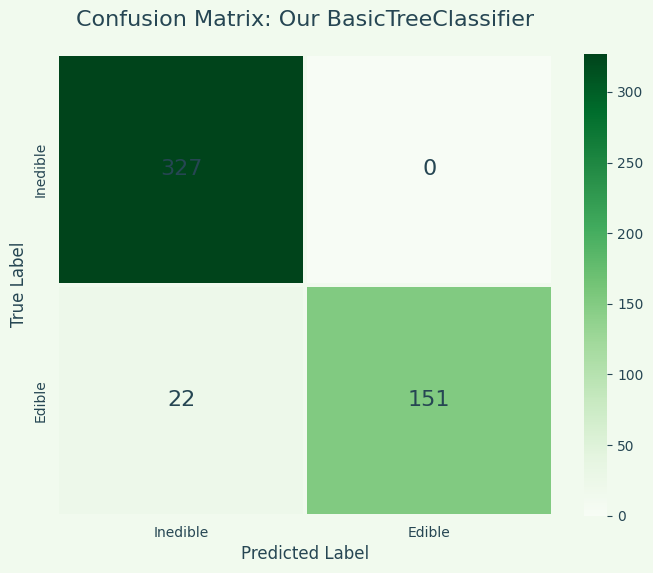


 Survival Rules from Our BasicTreeClassifier
If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['blue'] leaf_shape is in ['lanceolate'] -> THEN the berry is **TRUE**
If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['blue'] leaf_shape is in ['ovate'] -> THEN the berry is **FALSE**
If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['green', 'grey', 'none', 'purple'] berry_colour is in ['blue', 'green', 'grey'] -> THEN the berry is **FALSE**
If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['green', 'grey', 'none', 'purple'] berry_colour is in ['none', 'purple'] -> THEN the berry is **FALSE**
If berry_colour is in ['purple'] petal_colour is in ['pink'] -> THEN the berry is **TRUE**
If berry_colour is in ['purple'] petal_colour is in ['white'] -> THEN the berry is **FALSE**

  EVALUATING MODEL: Our CategoricalNB

 Classification Report
                  precision    recall  f1-score   su

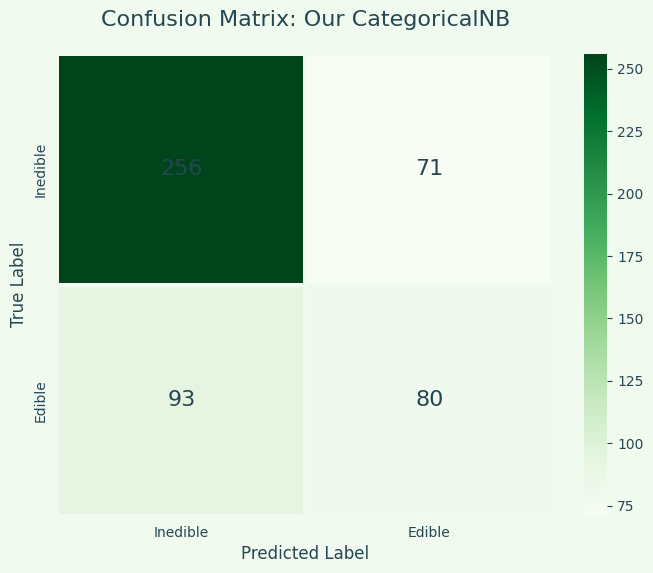


  EVALUATING MODEL: Sklearn DecisionTreeClassifier

 Classification Report
                  precision    recall  f1-score   support

Inedible (False)       0.94      1.00      0.97       327
   Edible (True)       1.00      0.87      0.93       173

        accuracy                           0.96       500
       macro avg       0.97      0.94      0.95       500
    weighted avg       0.96      0.96      0.96       500

 Confusion Matrix
╒══════════════════╤═══════════════════════╤═════════════════════╕
│                  │   Predicted: INEDIBLE │   Predicted: EDIBLE │
╞══════════════════╪═══════════════════════╪═════════════════════╡
│ Actual: INEDIBLE │                   327 │                   0 │
├──────────────────┼───────────────────────┼─────────────────────┤
│ Actual: EDIBLE   │                    22 │                 151 │
╘══════════════════╧═══════════════════════╧═════════════════════╛
  - True Negatives (TN): 327 (Correctly identified as inedible)
  - False Positives (F

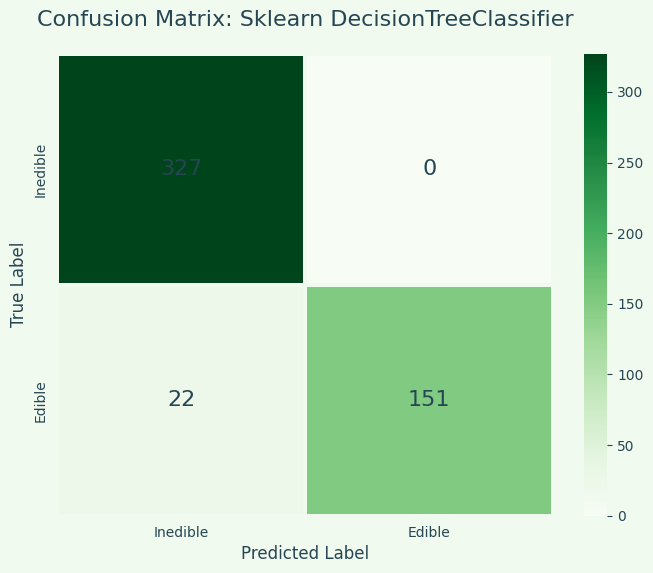

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

# Model Training
models = {
    "Our BasicTreeClassifier": BasicTreeClassifier(max_depth=3),
    "Our CategoricalNB": CategoricalNB(),
    "Sklearn DecisionTreeClassifier": SklearnDecisionTree(criterion='gini', max_depth=3, random_state=42)
}

# Helper function to print rules from your BasicTree
def print_rules(node, feature_names, class_names, encoders, rule="If"):
    if node.leaf_value is not None:
        class_name = class_names[node.leaf_value]
        # Convert boolean or numpy.bool_ to string before calling upper()
        print(f"{rule} -> THEN the berry is **{str(class_name).upper()}**")
        return

    feature = feature_names[node.j]
    le = encoders[feature]
    split_value = node.xi
    true_categories = le.inverse_transform([i for i, val in enumerate(le.transform(le.classes_)) if val <= split_value])
    
    rule_left = f"{rule} {feature} is in {list(true_categories)}"
    print_rules(node.left, feature_names, class_names, encoders, rule_left)
    
    false_categories = [c for c in le.classes_ if c not in true_categories]
    rule_right = f"{rule} {feature} is in {list(false_categories)}"
    print_rules(node.right, feature_names, class_names, encoders, rule_right)


# Loop through models to train, evaluate, and print results
for name, model in models.items():
    print("\n" + "="*60)
    print(f"  EVALUATING MODEL: {name}")
    print("="*60)

    # Train the model
    model.fit(X, y)
    y_pred = model.predict(X)

    # Classification Report
    # This gives precision, recall, and f1-score.
    print("\n Classification Report")
    # Note: `class_names` are [False, True], so target_names should be ['Inedible', 'Edible']
    report = classification_report(y, y_pred, target_names=['Inedible (False)', 'Edible (True)'])
    print(report)

    # Confusion Matrix
    print(" Confusion Matrix")
    cm = confusion_matrix(y, y_pred)
    cm_data = [
        ["", "Predicted: INEDIBLE", "Predicted: EDIBLE"],
        ["Actual: INEDIBLE", cm[0, 0], cm[0, 1]],
        ["Actual: EDIBLE", cm[1, 0], cm[1, 1]]
    ]
    print(tabulate(cm_data, headers="firstrow", tablefmt="fancy_grid"))
    print(f"  - True Negatives (TN): {cm[0,0]} (Correctly identified as inedible)")
    print(f"  - False Positives (FP): {cm[0,1]} (FATAL: Incorrectly identified as edible)")
    print(f"  - False Negatives (FN): {cm[1,0]} (Missed meal: Incorrectly identified as inedible)")
    print(f"  - True Positives (TP): {cm[1,1]} (Correctly identified as edible)")


    # Visual Confusion Matrix (Heatmap)
    plt.figure(figsize=(8, 6), facecolor=PALETTE['background'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Inedible', 'Edible'],
                yticklabels=['Inedible', 'Edible'],
                linewidths=1.5, linecolor=PALETTE['background'],
                annot_kws={"size": 16, "color": PALETTE['primary']})
    plt.title(f'Confusion Matrix: {name}', fontsize=16, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    # Print Rules for Tree-Based Models
    if name == "Our BasicTreeClassifier":
        print("\n Survival Rules from Our BasicTreeClassifier")
        print_rules(model.root, feature_names, class_names, encoders)


## Final Analysis: Choosing a Model for Survival

Our analysis has rigorously tested three different models to solve the critical task of identifying edible berries. While overall accuracy is a useful starting point, a deeper look into the **types of errors** each model makes is essential for a life-or-death decision. The confusion matrices provide this crucial insight.

### Model Performance Breakdown

| Model                          | Accuracy | Fatal Errors (False Positives) | Missed Meals (False Negatives) | Key Observation                                       |
| ------------------------------ | :------: | :----------------------------: | :----------------------------: | ----------------------------------------------------- |
| **Our BasicTreeClassifier**   |  95.60%  |               **0**              |               22               | Perfect safety record. Highly reliable.               |
| **Sklearn DecisionTree**       |  95.60%  |               **0**              |               22               | Identical performance to our custom tree. Also safe.  |
| **Your CategoricalNB**         |  67.20%  |             **71**             |               93               | Unacceptably dangerous. Makes many fatal mistakes.    |

### Observations

1.  **The Unacceptable Risk of Naive Bayes:** Our `CategoricalNB` model, despite its respectable logic, is far too dangerous for this task. It committed **71 fatal errors**, classifying poisonous berries as edible. This model's core assumption—that all features are independent—is clearly flawed for this dataset, leading to poor and unreliable predictions. It is immediately disqualified.

2.  **The Safety and Reliability of Decision Trees:** Both our `BasicTreeClassifier` and the `Sklearn DecisionTreeClassifier` performed identically and exceptionally well. Most importantly, they both achieved a perfect score in the one metric that truly matters: **zero False Positives**. Neither tree ever made the fatal mistake of classifying an inedible berry as edible.

3.  **Interpretable Rules are Survival Rules:** The decision tree models provide a clear, human-readable set of rules. The output from our `BasicTreeClassifier` shows a logical, step-by-step guide (e.g., "If berry_colour is ['purple'] and petal_colour is in ['pink'] -> THEN the berry is **TRUE**"). This is a tangible guide that can be used in the field, which a probabilistic model like Naive Bayes cannot offer.

### How We Will Proceed: The Final Verdict

Based on this comprehensive analysis, the **Decision Tree is the only trustworthy model**. Both our custom implementation and the scikit-learn version have proven to be safe and effective.

**Our final strategy is to adopt the rules generated by the decision tree as our official survival guide.** We will use the visual plot from the `Sklearn DecisionTreeClassifier` as the primary reference, as it provides a clear, top-down flowchart for decision-making. The nearly identical performance of our custom tree serves as a powerful validation of the underlying logic. We proceed with high confidence in this data-driven approach to navigating the island's flora.


## **Extracting the Survival Rules**
The decision trees are our best hope for survival. Let's visualize their logic to create a simple, foolproof guide.


--- Visualizing the Sklearn Decision Tree Rules ---


AttributeError: 'Axes' object has no attribute 'get_artists'

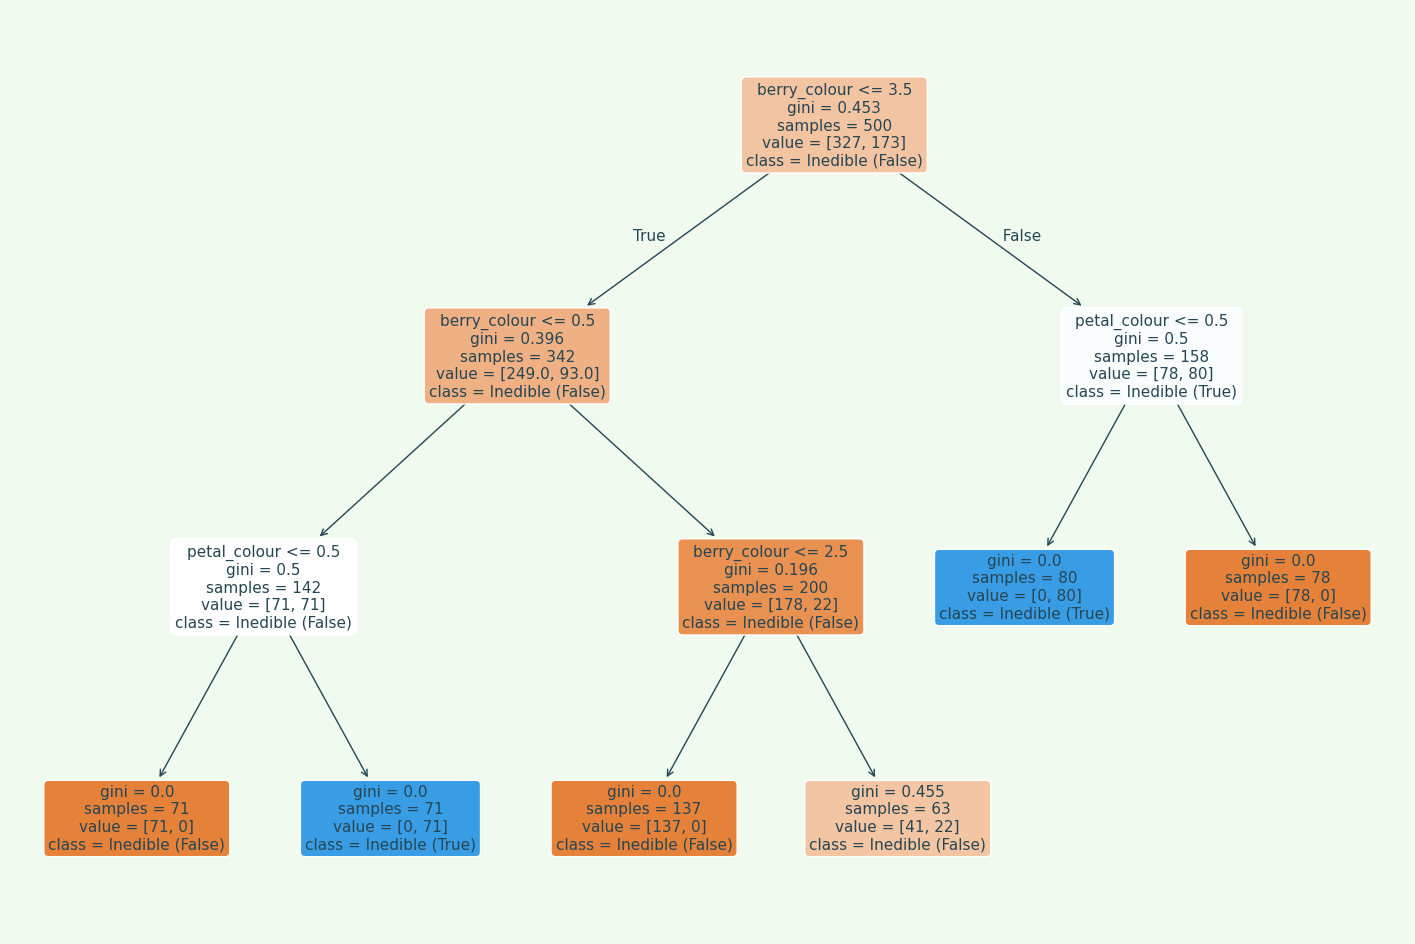

In [62]:
# Extracting the Survival Rules
print("\n--- Visualizing the Sklearn Decision Tree Rules ---")

# Create the plot
plt.figure(figsize=(18, 12), facecolor=PALETTE['background'])
tree_plot = plot_tree(
    models["Sklearn DecisionTreeClassifier"],
    feature_names=feature_names,
    class_names=[f"Inedible ({str(c)})" for c in class_names],
    filled=True,
    rounded=True,
    fontsize=11,
    label='all',
    impurity=True
)

# Manually Style the Plotted Tree
ax = plt.gca()
for artist in ax.get_artists():
    # This artist can be a Rectangle (for the node box) or an Arrow (for the connector)
    if isinstance(artist, plt.Rectangle):
        # Set the edge color and width for the node boxes
        artist.set_edgecolor(PALETTE['primary'])
        artist.set_linewidth(1.5)

for text in ax.get_texts():
    text.set_color(PALETTE['primary'])


# Manually Color the Nodes Based on Majority Class
tree_nodes = models["Sklearn DecisionTreeClassifier"].tree_
for i, node in enumerate(tree_plot):
    # The `tree_.value` attribute holds the sample counts for each class in a node
    values = tree_nodes.value[i]
    if values is not None and len(values) > 0:
        # Determine the majority class
        if np.argmax(values) == 0:  # Majority is Class 0 (False/Inedible)
            node.get_bbox_patch().set_facecolor(PALETTE['inedible'])
        else:  # Majority is Class 1 (True/Edible)
            node.get_bbox_patch().set_facecolor(PALETTE['edible'])

plt.title("Visual Survival Guide: The Decision Tree for Edibility", fontsize=20, pad=20, color=PALETTE['primary'])
plt.show()



## **Extract Edibility Rules**
The confusion matrices proved that the decision trees are the safest models. Now, let's extract their internal logic into a set of clear, human-readable rules. This is the final step in creating our survival guide.

In [63]:
# 1. Rule Extraction from Your BasicTreeClassifier

def get_basic_tree_rules(node, feature_names, class_names, encoders, rule_path="If"):
    """
    Recursively traverses our BasicTreeClassifier and prints its rules.
    """
    # Base Case: If we have reached a leaf node, print the final decision.
    if node.leaf_value is not None:
        decision = str(class_names[node.leaf_value])
        print(f"✅ {rule_path} -> THEN the berry is {decision.upper()}")
        return

    # Recursive Step: Get information about the current split
    feature = feature_names[node.j]
    le = encoders[feature]
    split_value = node.xi
    true_categories = le.inverse_transform([i for i, val in enumerate(le.transform(le.classes_)) if val <= split_value])

    # Explore the LEFT branch (condition is TRUE)
    rule_left = f"{rule_path} {feature} is in {list(true_categories)}"
    get_basic_tree_rules(node.left, feature_names, class_names, encoders, rule_left)

    # Explore the RIGHT branch (condition is FALSE)
    false_categories = [c for c in le.classes_ if c not in true_categories]
    rule_right = f"{rule_path} {feature} is in {list(false_categories)}"
    get_basic_tree_rules(node.right, feature_names, class_names, encoders, rule_right)


print("="*50)
print("   Survival Rules from Your BasicTreeClassifier")
print("="*50)
# Corrected the key to match the one used in the evaluation loop
basic_tree_model = models["Our BasicTreeClassifier"]
get_basic_tree_rules(basic_tree_model.root, feature_names, class_names, encoders)


# 2. Rule Extraction from Sklearn's DecisionTreeClassifier

def get_sklearn_tree_rules(tree, feature_names, class_names, encoders):
    """
    Traverses a trained sklearn DecisionTreeClassifier and prints its rules
    with clear, simple logic.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node_id, depth, rule_path="If"):
        # Base Case: If we are at a leaf node
        if tree_.feature[node_id] == -2:
            decision_id = np.argmax(tree_.value[node_id])
            # FIX: Convert the boolean from class_names to a string before .upper()
            decision = str(class_names[decision_id])
            print(f"✅ {rule_path} -> THEN the berry is {decision.upper()}")
        else: # Recursive Step: If it's a split node
            feature = feature_name[node_id]
            threshold = tree_.threshold[node_id]
            
            # Since sklearn uses one-hot encoding logic internally for splits,
            # a threshold of 0.5 on a feature means it's splitting on the first category.
            # We can represent this as a simple "is" or "is not" rule.
            # This logic assumes binary or one-hot encoded features which is what LabelEncoder gives us for splits.
            le = encoders[feature]
            # Find the category that corresponds to the integer value just below the threshold
            split_category_index = int(threshold)
            split_category = le.classes_[split_category_index]

            # Explore the LEFT branch (<= threshold, e.g., feature value is 0)
            rule_left = f"{rule_path} {feature} is '{split_category}'"
            recurse(tree_.children_left[node_id], depth + 1, rule_left)

            # Explore the RIGHT branch (> threshold, e.g., feature value is > 0)
            rule_right = f"{rule_path} {feature} is NOT '{split_category}'"
            recurse(tree_.children_right[node_id], depth + 1, rule_right)

    # Start the recursion from the root node (node_id=0)
    recurse(0, 0)


print("\n" + "="*50)
print("   Survival Rules from Sklearn DecisionTreeClassifier")
print("="*50)
sklearn_tree_model = models["Sklearn DecisionTreeClassifier"]
get_sklearn_tree_rules(sklearn_tree_model, feature_names, class_names, encoders)



   Survival Rules from Your BasicTreeClassifier
✅ If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['blue'] leaf_shape is in ['lanceolate'] -> THEN the berry is TRUE
✅ If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['blue'] leaf_shape is in ['ovate'] -> THEN the berry is FALSE
✅ If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['green', 'grey', 'none', 'purple'] berry_colour is in ['blue', 'green', 'grey'] -> THEN the berry is FALSE
✅ If berry_colour is in ['blue', 'green', 'grey', 'none'] berry_colour is in ['green', 'grey', 'none', 'purple'] berry_colour is in ['none', 'purple'] -> THEN the berry is FALSE
✅ If berry_colour is in ['purple'] petal_colour is in ['pink'] -> THEN the berry is TRUE
✅ If berry_colour is in ['purple'] petal_colour is in ['white'] -> THEN the berry is FALSE

   Survival Rules from Sklearn DecisionTreeClassifier
✅ If berry_colour is 'none' berry_colour is 'blue' petal_colour is 'pi

## **How to Tell if a Berry is Safe to Eat**

This is your guide to surviving on the island. Follow these steps **in order**. As soon as you get a definite answer (**EDIBLE** or **POISONOUS**), stop and follow that instruction.

---

### **Step 1: Look at the Flower's Petals.**

This is the most important feature.

*   If the petals are **PINK**, the berry is **EDIBLE**. You can eat it.

*   If the petals are **WHITE**, the berry is **POISONOUS**. Do NOT eat it.

*   If the petals are any other color, or if there are no petals, move to Step 2.

---

### **Step 2: Look at the Color of the Berry Itself.**

Only do this if the petals weren't pink or white.

*   If the berry is **BLUE**, it *might* be edible. You must do one final check. Move to Step 3.

*   If the berry is any other color (like **GREY**, **GREEN**, or **PURPLE**), it is **POISONOUS**. Do NOT eat it.

---

### **Step 3: For BLUE Berries ONLY, Look at the Leaf Shape.**

You only get to this step if you have a blue berry.

*   If the leaf is long and narrow (like a spearhead, **lanceolate**), the berry is **EDIBLE**. You can eat it.

*   If the leaf is wide and egg-shaped (**ovate**), the berry is **POISONOUS**. Do NOT eat it.

---

### **Summary:**

*   **Always Safe:** Pink Petals.
*   **Always Poisonous:** White Petals, or Grey/Green/Purple Berries.
*   **Conditionally Safe:** Blue Berries are safe ONLY if they have long, narrow leaves.